# MLND CAPSTONE PROJECT

**Project Summary:**  

In this project, we will train a model that can decode sequences of digits from natural images, and create an app that prints the numbers it sees in real time using Tensorflow library.

The data that we will be using is Street View House Numbers (SVHN), a large-scale dataset of house numbers in Google Street View images.

## Download matlab data

In [3]:
# Import required modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf

from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [4]:
# Download SVHN data from Stanford University repo
from urllib import urlretrieve
    
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  print('Found and downloaded', filename)
  return filename

In [5]:
# Download train, test and extra 32_32 matlab files for cropped digits
train_filename = maybe_download('train_32x32.mat')
test_filename = maybe_download('test_32x32.mat')
extra_filename = maybe_download('extra_32x32.mat')

Found and downloaded train_32x32.mat
Found and downloaded test_32x32.mat
Found and downloaded extra_32x32.mat


In [6]:
# Load matlab files using scipy.io library
import scipy.io as sio

train_data = sio.loadmat('train_32x32.mat', variable_names='X').get('X')
train_labels = sio.loadmat('train_32x32.mat', variable_names='y').get('y')
test_data = sio.loadmat('test_32x32.mat', variable_names='X').get('X')
test_labels = sio.loadmat('test_32x32.mat', variable_names='y').get('y')
# extra_data = sio.loadmat('extra_32x32.mat', variable_names='X').get('X')
# extra_labels = sio.loadmat('extra_32x32.mat', variable_names='y').get('y')

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
# print("extra data: ", extra_data.shape, extra_labels.shape)

train data:  (32, 32, 3, 73257) (73257, 1)
test data:  (32, 32, 3, 26032) (26032, 1)


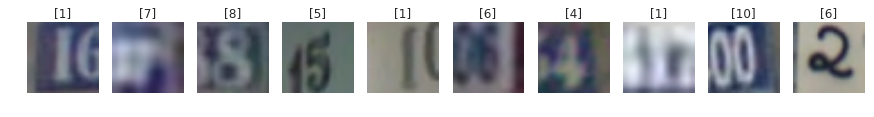

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[:,:,:,j])

## Pre-processing Data

In [8]:
# first we will normalize image data in range of -1 and 1.
train_data = train_data.astype('float32') / 128.0 - 1
test_data = test_data.astype('float32') / 128.0 - 1

# reshaping np array so that we can access data in CNN friendly format i.e. [i,:,:,:] from [:,:,:,i]
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data,(3, 0, 1, 2))

#chaning class labels range 1-10 to 0-9
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

# processing labels in CNN friendly format i.e. 1-hot-encoding
num_labels = 10
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
train_labels = (np.arange(num_labels) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(num_labels) == test_labels[:, None]).astype(np.float32)

print("train data: ", train_data.shape, train_labels.shape)
print("test data: ", test_data.shape, test_labels.shape)
print("sample one-hot encoding train label: ", train_labels[3])

train data:  (73257, 32, 32, 3) (73257, 10)
test data:  (26032, 32, 32, 3) (26032, 10)
sample one-hot encoding train label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [9]:
# Create Validation data from Train data
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, 
                                                                      test_size=0.1, random_state=42)

print("train data: ", train_data.shape, train_labels.shape)
print("valid data: ", valid_data.shape, valid_labels.shape)

train data:  (65931, 32, 32, 3) (65931, 10)
valid data:  (7326, 32, 32, 3) (7326, 10)


In [10]:
# Convert RGB to Greyscale
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_data)[:,:,:,:]
test_data_c = im2gray(test_data)[:,:,:,:]
valid_data_c = im2gray(valid_data)[:,:,:,:]

print("train data: ", train_data_c.shape, train_labels.shape)
print("test data: ", test_data_c.shape, test_labels.shape)
print("valid data: ", valid_data_c.shape, valid_labels.shape)

train data:  (65931, 32, 32, 1) (65931, 10)
test data:  (26032, 32, 32, 1) (26032, 10)
valid data:  (7326, 32, 32, 1) (7326, 10)


In [11]:
# shuffle dataset
from sklearn.utils import shuffle

train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
test_data, test_labels = shuffle(test_data, test_labels, random_state=0)

print("train data: ", train_data_c.shape, train_labels.shape)
print("test data: ", test_data_c.shape, test_labels.shape)
print("valid data: ", valid_data_c.shape, valid_labels.shape)

train data:  (65931, 32, 32, 1) (65931, 10)
test data:  (26032, 32, 32, 1) (26032, 10)
valid data:  (7326, 32, 32, 1) (7326, 10)


In [12]:
# Create pickle file to save processed data
pickle_file = 'SVHN_single.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_data': train_data,
    'train_labels': train_labels,
    'test_data': test_data,
    'test_labels': test_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1133720175


## Training the Model

In [13]:
# lets load data from pickle file we previously stored
data_file = 'SVHN_single.pickle' # redefined varaible in case you have completed above steps previously.

print('Tring to load pickle from %s' % data_file)

with open(data_file, 'rb') as file:
    svhn_datasets = pickle.load(file)
    train_data = svhn_datasets['train_data']
    train_labels = svhn_datasets['train_labels']
    test_data = svhn_datasets['test_data']
    test_labels = svhn_datasets['test_labels']
    del svhn_datasets # free up memory
    print('pickle loaded successfully!')

print("train data: ", train_data_c.shape, train_labels.shape)
print("test data: ", test_data_c.shape, test_labels.shape)
print("valid data: ", valid_data_c.shape, valid_labels.shape)

Tring to load pickle from SVHN_single.pickle
pickle loaded successfully!
train data:  (65931, 32, 32, 1) (65931, 10)
test data:  (26032, 32, 32, 1) (26032, 10)
valid data:  (7326, 32, 32, 1) (7326, 10)


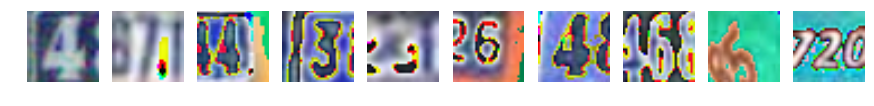

In [14]:
# Check to make sure image from pickle file is valid

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    # we will not display labels here as 1-hot-encoding cannot be viewed properly in little place
    ax[i].imshow(train_data[j,:,:,:])

## Prepare CNN using TensorFlow

In [15]:
# Weight initialization

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


# 2D Convolution and 2x2 Pooling

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [16]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

### Covnet Model: conv / pool / conv / pool / fully_connected / dropout / fully_connected

In [19]:
graph = tf.Graph()

with graph.as_default():
    
    # placeholders for input data batch_size x 32 x 32 x 1 and labels batch_size x 10
    x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-4, global_step=global_step, decay_steps=10000, decay_rate=0.97)

    # Conv Layer 1: with 32 filters of size 5 x 5 
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])

    x_image = tf.reshape(x, [-1, 32, 32, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
    # Pool
    h_pool1 = max_pool_2x2(h_conv1)

    # Conv Layer 2:  with 64 filters of size 5 x 5 
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    
    # Pool
    h_pool2 = max_pool_2x2(h_conv2)

    
    W_fc1 = weight_variable([8 * 8 * 64, 1024])
    b_fc1 = bias_variable([1024])
    
    # flatening output of pool layer to feed in FC layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
    
    # FC layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    # Output
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()

In [21]:
batch_size = 64
num_steps = 20001

with tf.Session(graph=graph) as session:
    session.run(tf.initialize_all_variables())
    print('Initialized')
    for i in xrange(num_steps):
        offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data_c[offset:(offset + batch_size), :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {x: batch_data, y_: batch_labels, keep_prob: 0.5}
        if i%500 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_data, y_: batch_labels, keep_prob: 1.0})
            valid_accuracy = accuracy.eval(feed_dict={x:valid_data_c, y_: valid_labels, keep_prob: 1.0})
            print("step: %d, training accuracy: %g, validation accuracy: %g" % 
                  (i,train_accuracy, valid_accuracy ))
        train_step.run(feed_dict={x: batch_data, y_: batch_labels, keep_prob: 0.5})
    
    test_accuracy = []
    for i in xrange(len(test_labels)/batch_size):
        batch_data = test_data_c[i * batch_size: (i * batch_size) + batch_size]
        batch_labels = test_labels[i * batch_size: (i * batch_size) + batch_size, :]
        test_accuracy.append(accuracy.eval(feed_dict={
                    x: batch_data, 
                    y_: batch_labels,
                    keep_prob: 1.0}))
    print('test accuracy %g' % np.mean(test_accuracy))
    session.close()
    print('session closed!')
    

Initialized
step: 0, training accuracy: 0.109375, validation accuracy: 0.134316
step: 500, training accuracy: 0.203125, validation accuracy: 0.184139
step: 1000, training accuracy: 0.203125, validation accuracy: 0.192192
step: 1500, training accuracy: 0.140625, validation accuracy: 0.195741
step: 2000, training accuracy: 0.1875, validation accuracy: 0.199154
step: 2500, training accuracy: 0.171875, validation accuracy: 0.200246
step: 3000, training accuracy: 0.25, validation accuracy: 0.19929
step: 3500, training accuracy: 0.1875, validation accuracy: 0.199973
step: 4000, training accuracy: 0.125, validation accuracy: 0.19697
step: 4500, training accuracy: 0.21875, validation accuracy: 0.198608
step: 5000, training accuracy: 0.1875, validation accuracy: 0.200246
step: 5500, training accuracy: 0.265625, validation accuracy: 0.198744
step: 6000, training accuracy: 0.15625, validation accuracy: 0.196014
step: 6500, training accuracy: 0.1875, validation accuracy: 0.199427
step: 7000, train